In [58]:
# Kuka iiwa + floating bottle + 2 cameras:
# ? Use DNN to segment depth images?
# 1. Get point cloud from depth image
# 2. Crop point cloud to grasping zone
# 3. Estimate surface normals
# 4. Select best grasp pose
# 5. Move to that pose

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (StartMeshcat, MeshcatVisualizer, DiagramBuilder, Parser, ConstantVectorSource,
                        Simulator, LeafSystem, RigidTransform, RotationMatrix, ProcessModelDirectives,
                        UniformlyRandomRotationMatrix, RandomGenerator, Rgba, LoadModelDirectivesFromString,
                        AbstractValue, PointCloud, Concatenate, AddMultibodyPlantSceneGraph, RollPitchYaw)
from manipulation.clutter import GenerateAntipodalGraspCandidate
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import FindResource
from manipulation.scenarios import (MakeManipulationStation, ycb, AddPackagePaths)

# For diagram viz
from IPython.display import SVG
import pydot

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [89]:
internal_directives = """
directives:
    
- add_directives:
    file: package://manipulation/schunk_wsg_50_welded_fingers.dmd.yaml

- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [-125.0, 0, 90.0]}
        translation: [.3, -.65, .6]

- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera0_origin
    child: camera0::base

- add_frame:
    name: camera1_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [-90., 0, -50]}
        translation: [-.3, -.9, .4]

- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera1_origin
    child: camera1::base

"""

model_directives = internal_directives + f"""
- add_model:
    name: ycb{3}
    file: package://drake/manipulation/models/ycb/sdf/{ycb[3]}
"""

In [1]:
rs = np.random.RandomState()  # this is for python
generator = RandomGenerator(rs.randint(1000)) # this is for c++

def make_internal_model():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    AddPackagePaths(parser)
    directives = LoadModelDirectivesFromString(internal_directives)
    ProcessModelDirectives(directives, parser)
    plant.Finalize()
    return builder.Build()

class GraspSelector(LeafSystem):
    def __init__(self, camera_body_indices):
        LeafSystem.__init__(self)
        model_point_cloud = AbstractValue.Make(PointCloud(0))
        self.DeclareAbstractInputPort("cloud0_W", model_point_cloud)
        self.DeclareAbstractInputPort("cloud1_W", model_point_cloud)
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()]))

        port = self.DeclareAbstractOutputPort(
            "grasp_selection", lambda: AbstractValue.Make(
                (np.inf, RigidTransform())), self.SelectGrasp)
        port.disable_caching_by_default()

        # Crop box
#         self._crop_lower = np.array([-0.5, -0.75, 0.5])
#         self._crop_upper = np.array([0.5, -0.45, 0.8])
        self._crop_lower = np.array([-.15, -.8, .25])
        self._crop_upper = np.array([.15, -.5, .55])

        self._internal_model = make_internal_model()
        self._internal_model_context = self._internal_model.CreateDefaultContext()
        self._rng = np.random.default_rng()
        self._camera_body_indices = camera_body_indices

    def SelectGrasp(self, context, output):
        body_poses = self.get_input_port(2).Eval(context)
        pcd = []
        for i in range(2):
            cloud = self.get_input_port(i).Eval(context)
            pcd.append(cloud.Crop(self._crop_lower, self._crop_upper))
            pcd[i].EstimateNormals(radius=0.1, num_closest=30)

            # Flip normals toward camera
            X_WC = body_poses[self._camera_body_indices[i]]
            pcd[i].FlipNormalsTowardPoint(X_WC.translation())
        merged_pcd = Concatenate(pcd)
        down_sampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)

        costs = []
        X_Gs = []
        for i in range(100):
            cost, X_G = GenerateAntipodalGraspCandidate(
                self._internal_model, self._internal_model_context,
                down_sampled_pcd, self._rng)
            if np.isfinite(cost):
                costs.append(cost)
                X_Gs.append(X_G)

        if len(costs) == 0:
            # Didn't find a viable grasp candidate
            X_WG = RigidTransform(RollPitchYaw(-np.pi / 2, 0, np.pi / 2),
                                  [0.5, 0, 0.22])
            output.set_value((np.inf, X_WG))
        else:
            best = np.argmin(costs)
            output.set_value((costs[best], X_Gs[best]))

class IIWA(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        builder = DiagramBuilder()
        self.station = builder.AddNamedSystem("manipulation_station", MakeManipulationStation(model_directives))
        self.plant = self.station.GetSubsystemByName("plant")
        
        # Add grasp selector
        grasp_selector = builder.AddNamedSystem("grasp_selector",
            GraspSelector(camera_body_indices=[
                              self.plant.GetBodyIndices(
                                  self.plant.GetModelInstanceByName("camera0"))[0],
                              self.plant.GetBodyIndices(
                                  self.plant.GetModelInstanceByName("camera1"))[0]
                          ]))
        builder.Connect(self.station.GetOutputPort("camera0_point_cloud"),
                        grasp_selector.get_input_port(0))
        builder.Connect(self.station.GetOutputPort("camera1_point_cloud"),
                        grasp_selector.get_input_port(1))
        builder.Connect(self.station.GetOutputPort("body_poses"),
                        grasp_selector.GetInputPort("body_poses"))

        self.visualizer = MeshcatVisualizer.AddToBuilder(
            builder, self.station.GetOutputPort("query_object"), meshcat)  
        
        self.diagram = builder.Build()
        
        self.context = self.diagram.CreateDefaultContext()
        station_context = self.diagram.GetMutableSubsystemContext(self.station, self.context)
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, self.context)
        
        # Choose a random orientation for the YCB object
        for body_index in self.plant.GetFloatingBaseBodies():
            body = self.plant.get_body(body_index)
            if body.name() != "body":
                tf = RigidTransform(
                        UniformlyRandomRotationMatrix(generator),
                        [0, -.65, .4])
                self.plant.SetFreeBodyPose(plant_context,
                                      body,
                                      tf)
                
        self.diagram.Publish(self.context)
        
    def get_grasp(self):
        
        grasp_selector = self.diagram.GetSubsystemByName("grasp_selector")
        grasp_context = self.diagram.GetSubsystemContext(grasp_selector, self.context)
        X_WG = grasp_selector.GetOutputPort("grasp_selection").Eval(grasp_context)[1]
        AddMeshcatTriad(meshcat, "X_WG", X_PT=X_WG)
    
        wsg_free = self.plant.GetBodyByName("body")
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, self.context)
        self.plant.SetFreeBodyPose(plant_context, wsg_free, X_WG)
        # Need to manually publish to see update in meshcat
        self.diagram.Publish(self.context)
    
        return X_WG
    
    def simulate(self, t):
        
        self.simulator = Simulator(self.diagram, self.context)
        self.simulator.set_target_realtime_rate(1.0)
        self.visualizer.StartRecording()
        self.simulator.AdvanceTo(t)
        self.visualizer.PublishRecording()
        
    def get_diagram(self):
        
        return self.diagram
    
    
meshcat.Delete()
iiwa = IIWA()
            

NameError: name 'np' is not defined

In [103]:
grasp = iiwa.get_grasp()
    
# iiwa.simulate(10)

# diagram = iiwa.get_diagram()
# SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())
    
# depth_ims = iiwa.get_depth_ims()
# plt.rcParams["figure.figsize"] = (15,30)
# fig_d, (ax1_d, ax2_d) = plt.subplots(1,2)
# ax1_d.imshow(depth_ims[0])
# ax2_d.imshow(depth_ims[1])

# lower = np.array([-.15, -.8, .25])
# upper = np.array([.15, -.5, .55])
# [p0, p1] = iiwa.get_point_clouds()
# meshcat.SetObject("cam0_output", p0.Crop(lower, upper), point_size=0.003, rgba=Rgba(1.0, 0, 0))
# meshcat.SetTransform("cam0_output", RigidTransform())
# meshcat.SetObject("cam1_output", p1.Crop(lower, upper), point_size=0.003, rgba=Rgba(0, 1.0, 0))
# meshcat.SetTransform("cam1_output", RigidTransform())

# has_normals = p0.EstimateNormals(0.2, 10)
# print(has_normals)
# if has_normals:
#     n0 = p0.normals()
#     for i in range(len(n0)):
#         name = 'normal_vec_{}'.format(i)
#         AddMeshcatTriad(meshcat, name, length=0.01,
#                         radius=0.001, X_PT=n0[i])

# label_ims = iiwa.get_label_ims()
# fig_p, (ax1_p, ax2_p) = plt.subplots(1,2)
# ax1_p.imshow(label_ims[0])
# ax2_p.imshow(label_ims[1])


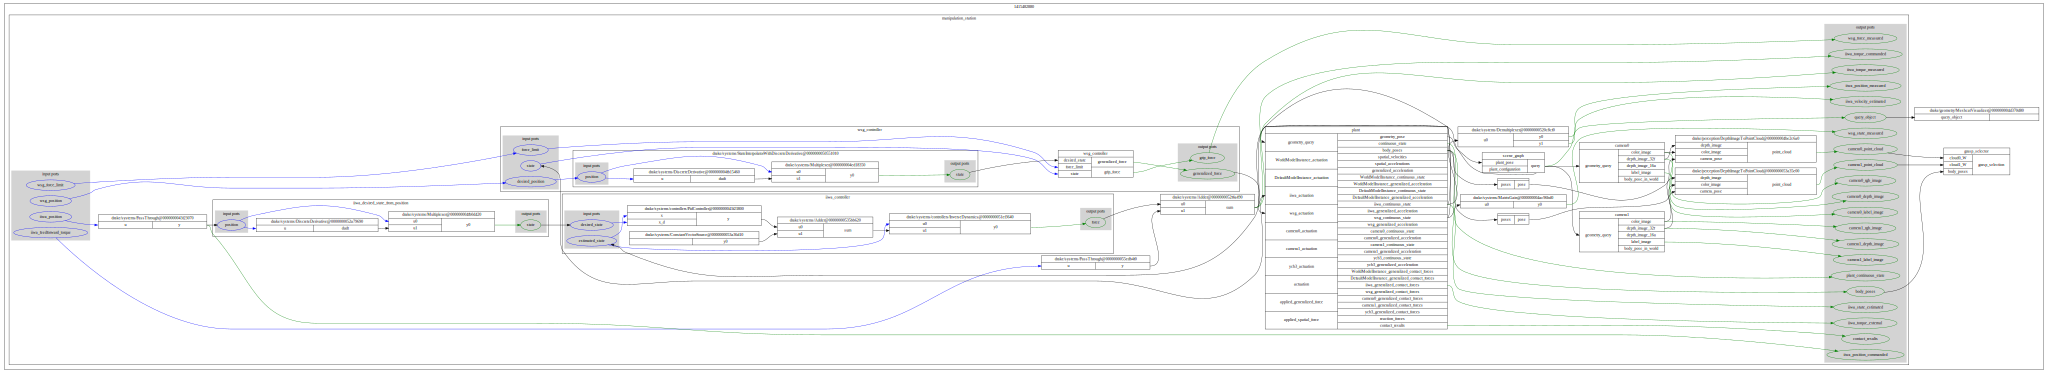

In [54]:
diagram = iiwa.get_diagram()
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())